In [51]:

# Heavily borrows from https://github.com/Priesemann-Group/covid19_inference

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import pandas as pd
import datetime

import pymc3 as pm

import pickle
import datetime

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

import sys
sys.path.append('..')
import ModelInfo



## single Case Overview

| time | event | distribution | RKI |
|------|-------|--------------|-----|
| -4 | infected | |
| -2... | infectious | lognormal | 
| 0...2 | onset of illness | | RefDate |
| +x | tested | | Meldedatum |
| x+y | reported to RKI | | first appearence in DB |

* number of RefDate is epidemic curve (EpiCurve), i.e. number with cases of onset of illness known on a given date
* numner of infections on a date is roughly EpiCurve shifted forward 4-5 days
* Reported Meldedatum not the date, the data appears in the RKI-Dataset, but Meldung to lower-level-authorities


<MultiTrace: 2 chains, 400 iterations, 31 variables>
(800, 13)
(800, 88)
[5.6137385  5.6137385  5.6137385  5.43553225 5.41991638 5.43623352
 5.42009671 5.42009671 5.42009671 5.42009671 5.24814182 4.95379825
 2.07623022 1.77224236 1.77224236 1.77224236 1.77224236 1.71601896
 1.91053064 3.98202581 4.18291521 4.18291521 4.18291521 4.18291521
 4.05015902 3.8532452  1.94581992 1.74244762 1.74244762 1.74244762
 1.74244762 1.68719313 1.61031698 0.8691392  0.78974753 0.78974753
 0.78974753 0.78974753 0.76467933 0.76740789 0.82072592 0.82354214
 0.82354214 0.82354214 0.82354214 0.79742199 0.7923882  0.7663686
 0.76117101 0.76117101 0.76117101 0.76117101 0.73701643 0.7333335
 0.71932569 0.71552157 0.71552157 0.71552157 0.71552157 0.69282119
 0.69416891 0.7308362  0.73222843 0.73222843 0.73222843 0.73222843
 0.70899387 0.7131598  0.77953281 0.78383321 0.78383321 0.78383321
 0.78383321 0.75898509 0.79253249 1.16486324 1.19950233 1.19950233
 1.19950233 1.19950233 1.16155387 1.1710914  1.3073781  1.

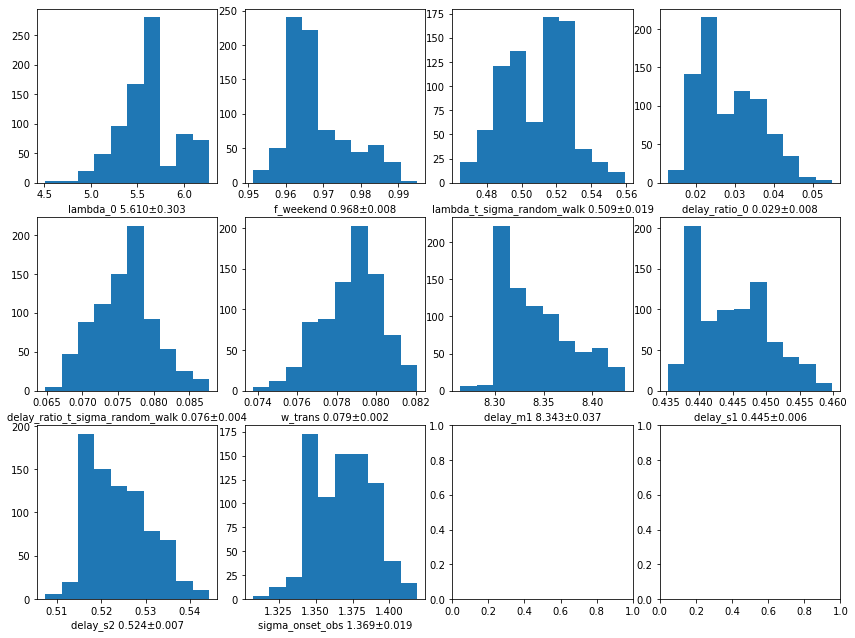

In [261]:
with open("../traces/trace235838_Rsym3_filter.dat","rb") as f:
    trace = pickle.load(f)
    model = pickle.load(f)
    datasets = pickle.load(f)

with open("../data/onset_by_date_missing.pickle","rb") as f:
    onsets_per_date = pickle.load(f)
    
print(trace)
print(trace.lambda_t_random_walk.shape)
print(trace.lambda_t.shape)
print(np.mean(trace.lambda_t,axis=0))

trd = {}
for name in trace.varnames:
    if "log__" not in name and "interval__" not in name:
        
        s,dt = "",trace[name]
        
        if dt.ndim == 1:
            s = "%.3f±%.3f"%(np.mean(dt,axis=0),np.std(dt,axis=0))
            trd[name] = (dt,s,)
        print((name+" "*20)[:20],trace[name].shape,s)

n2 = int(np.ceil(np.sqrt(len(trd))))
fig, axes = plt.subplots(int(len(trd)//n2+1),n2 , figsize = (n2*3,3*(len(trd)//n2+1)),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.2,left=0.05,right=0.98,top=0.96,bottom=0.05)
for i,k in enumerate(trd.keys()):
    v = trd[k]
    ax = axes[i//n2,i%n2]
    ax.hist(v[0])
    ax.set_xlabel(k+" "+v[1])

(88, 215) (2, 88, 67)


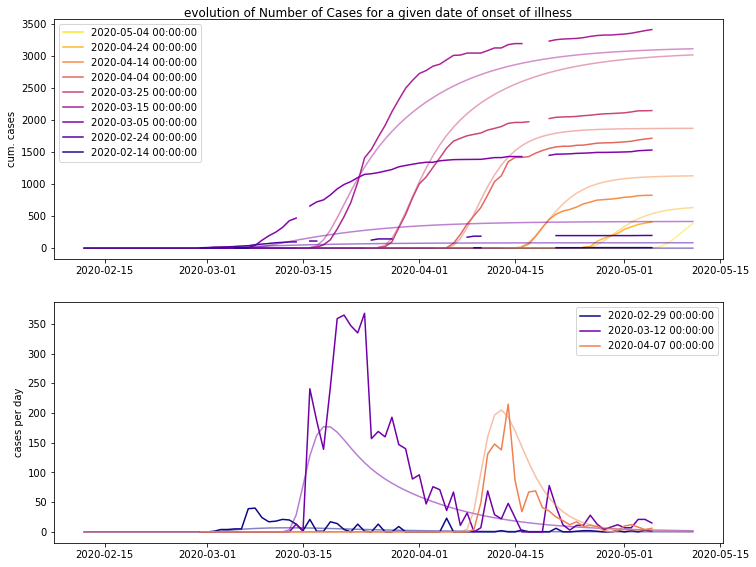

In [262]:
ta = pd.date_range(datetime.date(2020,2,12), periods=120, freq='D')


fig, axes = plt.subplots(2,1 , figsize = (10,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
bx = axes[1,0]
plasma = plt.cm.plasma


#print(trace.per_day_curve)

pdd = np.mean(trace.per_day_curve_t,axis=0)
pdc,pdcs = np.cumsum(pdd,axis=1),np.percentile(trace.per_day_curve_s,axis=0,q=(12.5,87.5))

print(pdc.shape,pdcs.shape)
#for i in reversed(range(pdc.shape[1])[0:83:7]):
for i in reversed(range(pdc.shape[1])[2:83:10]):
    c = plasma(i/85)
    ax.plot(ta[17:67+17],onsets_per_date[:][i],color=c,label=ta[i])
    
    ax.plot(ta[:90],pdc[i][:90],color=c,alpha=.5)
   # ax.fill_between(ta[17:66+17],*(pdcs[:,i]),color=c,alpha=.2)

for i in [17,29,55]:
    c = plasma((i-17)/(55))
    bx.plot(ta[17:67+17],np.concatenate([[0],np.diff(onsets_per_date[:][i])]),color=c,label=ta[i])
    bx.plot(ta[:90],pdd[i][:90],color=c,alpha=.5)
ax.set_ylabel("cum. cases")
bx.set_ylabel("cases per day")
fig.suptitle("evolution of Number of Cases for a given date of onset of illness")
_= ax.legend()
_= bx.legend()

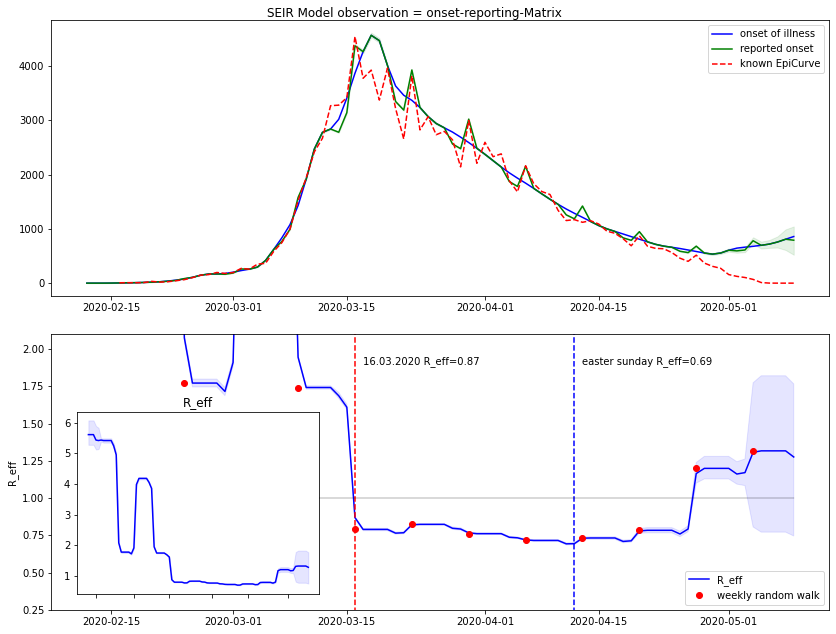

In [263]:
ts = pd.date_range(model.startdate,periods=model.length,freq='D')


fig, axes = plt.subplots(2, 1, figsize = (12,9),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.08,right=0.98,top=0.96,bottom=0.05)
fig.suptitle("SEIR Model observation = onset-reporting-Matrix")

ax = axes[0,0]

ax.plot(ts,np.mean(trace.onset_of_illness_t,axis=0),color="blue",label="onset of illness")
ax.plot(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),color="green",label="reported onset")
ax.fill_between(ts,*np.percentile(trace.reported_onset_of_illness_t,axis=0,q=(12.5,87.5)),alpha=.1,color="green")
ax.plot(ts[4:],epi_curve[:-6],"--",color="red",label="known EpiCurve")
ax.legend()

bx = axes[1,0]
lambda_tm = np.mean(trace.lambda_t,axis=0)
bx.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
bx.plot(ts,lambda_tm,color="blue",label="R_eff")
bx.set_ylabel("cases")

lockdown = datetime.date(2020,3,16)
bx.plot([lockdown]*2,[4,0],"--",color="red")
bx.text(lockdown+datetime.timedelta(days=1),1.9,"16.03.2020 R_eff=%.2f"%lambda_tm[(lockdown-model.startdate).days])
bx.set_ylabel("R_eff")

easter = datetime.date(2020,4,12)
bx.plot([easter]*2,[4,0],"--",color="blue")
bx.text(easter+datetime.timedelta(days=1),1.9,"easter sunday R_eff=%.2f"%lambda_tm[(easter-model.startdate).days])
bx.plot([ts[0],ts[-1]],[1,1],linewidth=.3,color="black")
bx.plot((ts[7::7]-datetime.timedelta(days=model.weekoffset)),np.mean(trace.lambda_t_random_walk,axis=0)[1:]+np.mean(trace.lambda_0),"o",color="red",label="weekly random walk")
bx.legend(loc=4)
bx.set_ylim(0.25,2.1)

cx = fig.add_axes([.11,.075,.28,.28])
cx.set_title("R_eff")
cx.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
cx.plot(ts,lambda_tm,color="blue")

#cx.plot(ta[:len(trace.lambda_t[0])],np.median(trace.lambda_t,axis=0))
#cx.fill_between(ta[:len(trace.lambda_t[0])],*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
#cx.set_xticks(dtx)
_ = cx.set_xticklabels([],rotation=20,horizontalalignment='right')

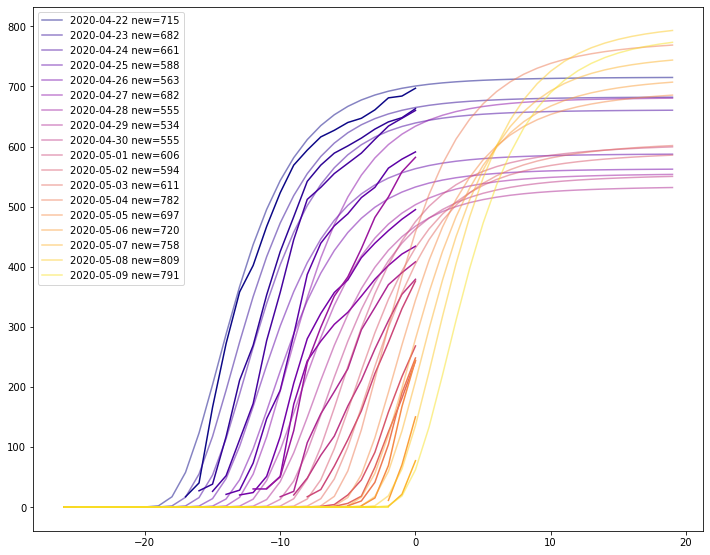

In [297]:
ta = pd.date_range(datetime.date(2020,2,12), periods=120, freq='D')

fig, axes = plt.subplots(1,1 , figsize = (10,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
plasma = plt.cm.plasma

pdd = np.mean(trace.per_day_curve_t,axis=0)
pdc,pdcs = np.cumsum(pdd,axis=1),np.percentile(trace.per_day_curve_s,axis=0,q=(12.5,87.5))

m =np.mean(trace.reported_onset_of_illness_t,axis=0)
start = 70
for i in range(start,model.length):
    c = plasma((i-start)/(model.length-start))
    ax.plot(range(-25,20),pdc[i][65:110],label=("%s new=%d")%(("%s"%ta[i])[:10],m[i]),color=c,alpha=.5)
    ax.plot(range(-26,1),onsets_per_date[i-5][40:],color=c)
    
ax.legend()



## Model overview
* intial distribution of imported cases
* weekly priors for R_eff and delay_ratio, smoothed (3 day window/linear interpolation)
* model reporting-delay i.e. time till case appears in RKI-database
* for each day, generate distribution, when cases appear as 'onset known' in RKI-database
* observation: for each date: vector of 'onset knwon' by date they appear in RKI-database
* Hope is to estimate current reporting-delay
* side project: delay cases to generate death/day

**Only models based on known onsets of illness!**


ValueError: x and y must have same first dimension, but have shapes (94,) and (88,)

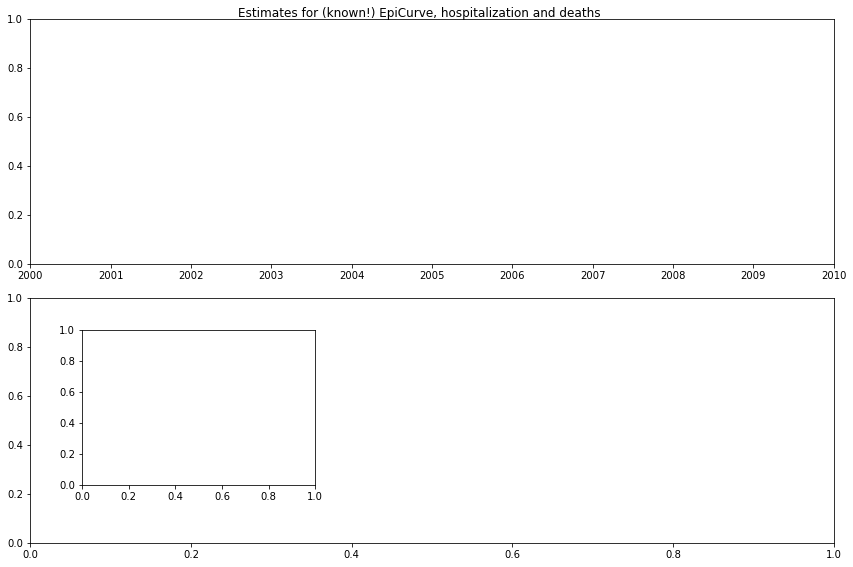

In [204]:
dtx = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15),datetime.date(2020,5,1)]
dtx += [datetime.date(2020,5,15)]

epi_curve = [7, 9, 8, 10, 33, 19, 26, 45, 64, 102, 147, 158, 197, 179, 195, 272, 258, 350, 366, 585, 747, 997, 1521, 1944, 2421, 2672, 3272, 3282, 3422, 4546, 3778, 3929, 3376, 3964, 3220, 2659, 3822, 2826, 3069, 2737, 2798, 2644, 2144, 2999, 2210, 2597, 2332, 2384, 1886, 1683, 2165, 1835, 1689, 1635, 1342, 1154, 1171, 1122, 1152, 1090, 959, 919, 819, 689, 874, 681, 641, 634, 564, 460, 402, 516, 370, 310, 274, 158, 125, 104, 69, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epi_curve = np.array(epi_curve,dtype=np.float64)
rki_reported = [0,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,64,97,130,209,223,262]
rki_reported = np.array(rki_reported)
deaths = [-1]*17+[-1,-1,-1,-1,-1,-1,0,1,2,0,3,4,0,0,0,8,11,16,8,31,28,35,49,55,72,64,66,128,149,140,145,141,184,92,173,254,246,266,171,129,126,170,285,315,299,242,184,110,194,281,215,227,179,140,110,163,202,173,193,94,74,43,139,165]#deaths = [0]*4+deaths
deaths = np.asarray(deaths,dtype=np.float64)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
fig.suptitle('Estimates for (known!) EpiCurve, hospitalization and deaths')
ax = axes[0,0]
bx = axes[1,0]
cx = fig.add_axes([.11,.15,.27,.27])

ax.plot(ta[:94],np.median(trace.infected_t,axis=0),color="red",alpha=.5,label="new_infected")
ax.plot(ta[4:94+4],np.median(trace.infected_t,axis=0),color="blue",alpha=.5,label="new_infected_shifted")
ax.fill_between(ta[:94],*np.percentile(trace.infected_t, axis=0, q=(12.5,87.5)),color="red",alpha=.1)

#ax.plot(ta[:83],np.median(trace.initial_t,axis=0),c="purple",label="Imported")
bx.plot(ta[:100],np.sum(np.mean(trace.per_day_curve_t,axis=0),axis=0)[:100],label="reported")
#ax.plot(ta[17:83],*(np.percentile(trace.per_day_curve_s,axis=0,q=(12.5,87.5))) )

ax.plot(ta[4:len(epi_curve)+4],epi_curve,"--",color="blue",label="EpiCurve")
bx.plot(ta[17+4:17+4+len(rki_reported)],rki_reported,"--",color="orange",label="reported")
rki_reported

ax.set_ylabel("cases per day")
ax.legend(loc=1)
ax.set_xticks(dtx)
ax.set_xticklabels(dtx)

if False:
    bx.plot(ta[:len(deaths)],deaths,color="red",label="deaths")
    bx.plot(ta[:94],np.median(trace.dead_t,axis=0),color="orange")
    bx.fill_between(ta[:83],*np.percentile(trace.dead_t, axis=0, q=(12.5,87.5)),color="orange",alpha=.2)

bx.set_ylabel("cases per day")
bx.legend(loc=1)
bx.set_xticks(dtx)
bx.set_xticklabels(dtx)

cx = fig.add_axes([.11,.15,.27,.27])
cx.set_title("R_eff")
#cx.plot(ta[:len(trace.lambda_t[0])],np.median(trace.lambda_t,axis=0))
#cx.fill_between(ta[:len(trace.lambda_t[0])],*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
#cx.set_xticks(dtx)
#_ = cx.set_xticklabels(dtx,rotation=20,horizontalalignment='right')

delay_m1 8.34 0.037
delay_s1 0.44 0.006
delay_s2 0.52 0.007
delay_m2 fixed to 20.000
50 precent known after 7 days after incubation


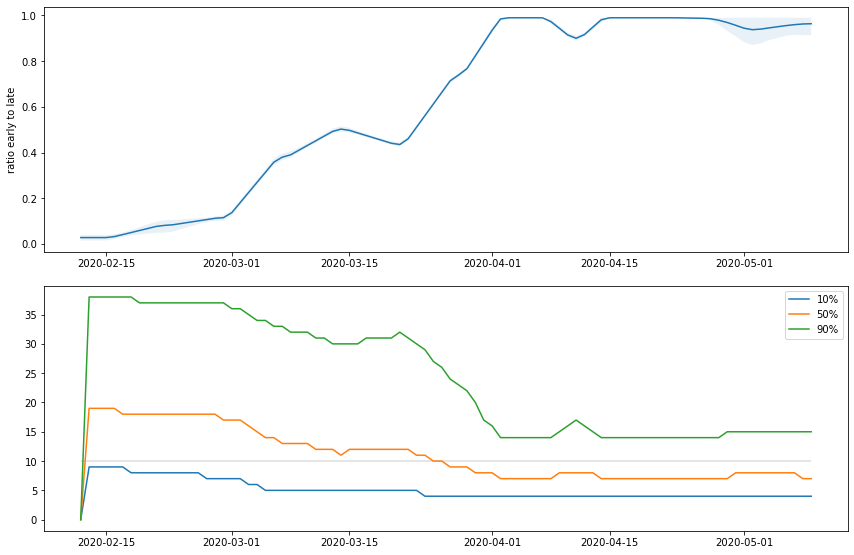

In [273]:
def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

def reportDelayDist(x, mu1, sig1, mu2, sig2, r ):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    r = tt.clip(r,0,1)
    d1 = tt_lognormal(x,mu1,sig1)
    d2 = tt_lognormal(x,mu2,sig2)
    
    ds = r*d1 + (1-r)*d2
    
    return ds / (tt.sum(ds) + 1e-12)



v = ["delay_m1","delay_s1","delay_s2"]
for n in v:
    print(n,"%.2f %.3f"%(np.mean(trace[n],axis=0),np.std(trace[n],axis=0)))
print("delay_m2 fixed to %.3f"%20)

m1,m2,s1,s2 = np.mean(trace.delay_m1,axis=0),20,np.mean(trace.delay_s1,axis=0),np.mean(trace.delay_s2,axis=0)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
bx = axes[1,0]
dlr = np.mean(trace.delay_ratio_t,axis=0)
ax.plot(ts,dlr)
ax.fill_between(ts,*np.percentile(trace.delay_ratio_t,axis=0,q=(12.5,87.5)),alpha=.1)

ax.set_ylabel("ratio early to late")

py = {10:[0]*len(ts),50:[0]*len(ts),90:[0]*len(ts)}
for i in range(len(ts)):
    d = pdc[i]
    m = np.mean(trace.reported_onset_of_illness_t,axis=0)[i]
    for j,dj in enumerate(d):
        if dj < m*.1:
            py[10][i] = j-i+1
        if dj < m*.5:
            py[50][i] = j-i+1
        if dj < m*.9:
            py[90][i] = j-i+1

bx.plot([ts[0],ts[-1]],[10,10],linewidth=.2,color="black")
bx.plot(ts,py[10],label="10%")
bx.plot(ts,py[50],label="50%")
bx.plot(ts,py[90],label="90%")
bx.legend()

print("50 precent known after %d days after incubation"%py[50][-1])
#    print(dlr[i])
#    print(reportDelayDist(np.arange(60),m1,s1,m2,s2,dlr[i]))
#    bx.plot()

(array([ 10.,  15.,  35.,  28.,  45.,  26.,  64., 141.,  34.,   2.]),
 array([0.02031885, 0.02214331, 0.02396778, 0.02579224, 0.02761671,
        0.02944117, 0.03126564, 0.03309011, 0.03491457, 0.03673904,
        0.0385635 ]),
 <a list of 10 Patch objects>)

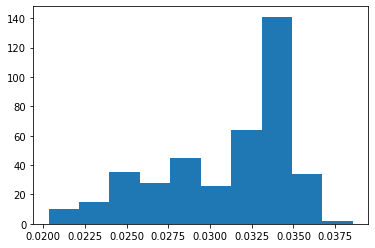

In [196]:
plt.hist(trace.delay_ratio_0)